# k nearest neighbors example
Chronic kidney disease data

In [35]:
import numpy as np
from datascience import *
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', UserWarning)
from IPython.display import Image
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from datascience import *

## Metadata
```
age in years30
blood pressure in mm/Hg80
pecific gravity in nominal1.1
albumin in nominal(1-5)3
sugar in nominal2
rbc(1-normal,0-abnormal)0
pus cell(1-normal,0-abnormal)1
pus cell clumps(1-present,0-not present)1
bacteria(1-present,0-not present)1
blood glucose random120
blood urea30
serum creatinione1.8
sodium104
potassium3.2
hemoglobin12.2
packed cell volume32
white blood cell count9600
red blood cell count4.4
hypertension0
appetite1
pedal edema0
anemia1
ckd is positive
```

In [36]:
url = "https://raw.githubusercontent.com/vamshikrishnajr/chronic-kidney-disease-diagnosis/master/kidney_disease.csv"
ckd_tbl = Table().read_table(url)
ckd_tbl.show(3)

id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48,80,1.02,1,0,nan,normal,notpresent,notpresent,121,36,1.2,nan,nan,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.02,4,0,nan,normal,notpresent,notpresent,nan,18,0.8,nan,nan,11.3,38,6000,nan,no,no,no,good,no,no,ckd
2,62,80,1.01,2,3,normal,normal,notpresent,notpresent,423,53,1.8,nan,nan,9.6,31,7500,nan,no,yes,no,poor,no,yes,ckd


### We will look at a subset of the features

In [37]:
ckd = ckd_tbl.select('hemo', 'bgr', 'wc', 'classification')
ckd.show(3)

hemo,bgr,wc,classification
15.4,121,7800,ckd
11.3,nan,6000,ckd
9.6,423,7500,ckd


## To use K-means, the targets and features all need to be numbers.

In [38]:
def classification2number(classification):
    if classification == "ckd":
        classification = 1
    elif classification == "notckd":
        classification = 0
    else:
        print("Classification", classification, "not recognized.")
    return classification

In [39]:
# Test our function
classification2number('ckd')

1

In [40]:
ckd_tbl.with_column(
    'target',
    ckd_tbl.apply(classification2number, 'classification')
)

ckd_tbl.show(3)

Classification ckd	 not recognized.
Classification ckd	 not recognized.


id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48,80,1.02,1,0,nan,normal,notpresent,notpresent,121,36,1.2,nan,nan,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.02,4,0,nan,normal,notpresent,notpresent,nan,18,0.8,nan,nan,11.3,38,6000,nan,no,no,no,good,no,no,ckd
2,62,80,1.01,2,3,normal,normal,notpresent,notpresent,423,53,1.8,nan,nan,9.6,31,7500,nan,no,yes,no,poor,no,yes,ckd


## What is the problem here? 

In [41]:
np.unique(ckd.column('classification'))

array(['ckd', 'ckd\t', 'notckd'],
      dtype='<U6')

### We have to clean the data or modify our function.

In [42]:
def classification2number(classification):
    if classification == "ckd":
        classification = 1
    elif classification == "ckd\t":
        classification = 1
    elif classification == "notckd":
        classification = 0
    else:
        print("Classification", classification, "not recognized.")
    return classification

### Try again

In [43]:
ckd = ckd.with_column(
    'target',
    ckd.apply(classification2number, 'classification')
)

ckd.show(3)

hemo,bgr,wc,classification,target
15.4,121,7800,ckd,1
11.3,nan,6000,ckd,1
9.6,423,7500,ckd,1


## But we still have nans in our data

In [48]:
df = ckd.to_df()
df = df.dropna()
ckd = Table.from_df(df)
ckd.show(3)

hemo,bgr,wc,classification,target
15.4,121,7800,ckd,1
9.6,423,7500,ckd,1
11.2,117,6700,ckd,1


### We need to standarize the data

In [49]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz))/np.std(xyz)  

In [50]:
# Reduce this to just three predictors and one target
# Standardize the predictor columns
ckd_s = Table().with_columns(
    "Hemoglobin",
    standard_units(ckd.column("hemo")),
    "Glucose",
    standard_units(ckd.column("bgr")),
    "White Blood Cell Count",
    standard_units(ckd.column("wc")),
    "Target",
    (ckd.column("target")),
)

In [51]:
ckd_s.show(3)

Hemoglobin,Glucose,White Blood Cell Count,Target
0.83448,-0.284472,-0.218277,1
-1.16476,3.57717,-0.321034,1
-0.613245,-0.33562,-0.595052,1


In [52]:
ckd_s.stats()

statistic,Hemoglobin,Glucose,White Blood Cell Count,Target
min,-3.40529,-1.55038,-2.13641,0
max,1.66175,4.43389,6.15265,1
median,0.179557,-0.322833,-0.149772,0
sum,1.10467e-13,-3.27516e-14,-3.4639e-14,128


In [53]:
# Add a column with a color value that depends on the Class
# gold for no kidney disease, blue for kidney disease
color_table = Table().with_columns(
    'Target', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd_s = ckd_s.join('Target', color_table)

In [54]:
ckd_s

Target,Hemoglobin,Glucose,White Blood Cell Count,Color
0,0.696601,-0.041521,0.672283,gold
0,1.38599,-0.936604,0.466769,gold
0,1.00683,-0.783161,0.227003,gold
0,0.83448,-0.310046,-0.766314,gold
0,0.00720848,-0.565784,-0.0470155,gold
0,0.214026,-0.284472,0.261255,gold
0,0.524253,-0.156603,0.775039,gold
0,0.351905,-0.668079,0.227003,gold
0,0.317435,-0.578571,-0.0127632,gold
0,1.07577,-0.501849,-1.41711,gold


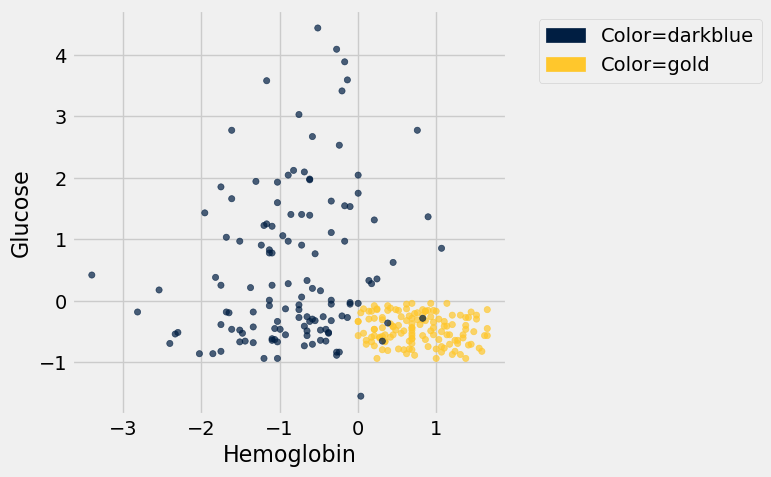

In [55]:
ckd_s.scatter('Hemoglobin', 'Glucose', group='Color')

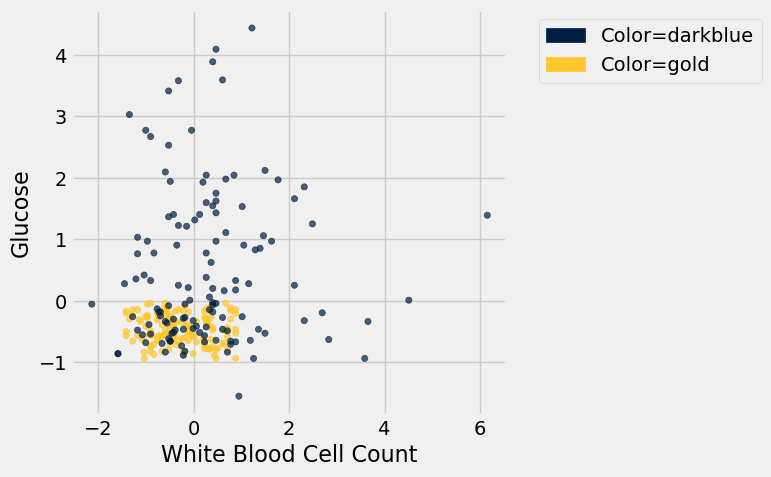

In [56]:
ckd_s.scatter('White Blood Cell Count', 'Glucose', group='Color')

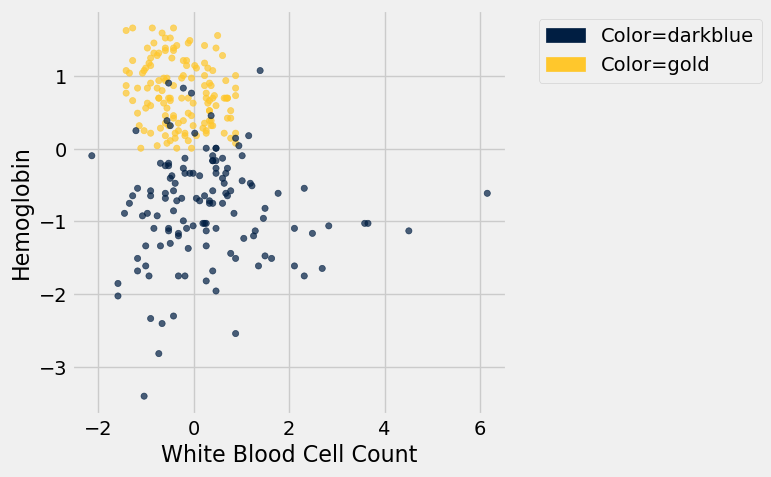

In [57]:
ckd_s.scatter('White Blood Cell Count', 'Hemoglobin', group='Color')

### Split our data into training and test datasets

In [58]:
train, test = ckd_s.split(int(ckd_s.num_rows*0.8))
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

210 training and 53 test instances.


In [59]:
train.show(3)

Target,Hemoglobin,Glucose,White Blood Cell Count,Color
0,0.80001,-0.386767,-0.663557,gold
1,-1.6818,-0.182177,0.398264,darkblue
0,0.83448,-0.310046,-0.766314,gold


In [60]:
test.show(3)

Target,Hemoglobin,Glucose,White Blood Cell Count,Color
1,-0.647715,0.329299,-0.903323,darkblue
0,0.696601,-0.284472,-0.526548,gold
0,0.696601,-0.693653,0.63803,gold


In [61]:
def distance(point1, point2):
    """Returns the Euclidean distance between point1 and point2.
    
    Each argument is an array containing the coordinates of a point."""
    return np.sqrt(np.sum((point1 - point2)**2))

In [63]:
def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2)) # Need to convert rows into arrays

In [64]:
test_point_row = test.drop("Target","Color").row(9)
train_point_row = train.drop("Target","Color").row(8)

In [65]:
np.array(train_point_row)

array([-1.61286421,  1.65913696,  2.11087885])

In [66]:
row_distance(train_point_row,test_point_row)

3.9073119116994683

In [67]:
def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))

In [68]:
test.row(31)

Row(Target=1, Hemoglobin=0.041678109652928008, Glucose=-1.550375362423311, White Blood Cell Count=0.94630094607924853, Color='darkblue')

In [69]:
training = train.drop("Color")
example = test.drop("Target","Color").row(31)
k = 8
output = "Target"

cl_knn = closest(training, example, k, output)
cl_knn

Target,Hemoglobin,Glucose,White Blood Cell Count,Distance
1,-0.268549,-0.834309,0.706535,0.816382
0,0.0761477,-0.527423,0.877796,1.02582
0,0.696601,-0.795948,0.706535,1.02741
0,0.593192,-0.795948,0.466769,1.05037
0,0.420844,-0.591358,0.706535,1.05876
1,-0.578775,-0.70644,0.775039,1.06138
0,0.731071,-0.885456,0.432517,1.0869
0,0.524253,-0.783161,0.32976,1.09618


### We can use most frequent value for the class as the prediction (like majority)

In [70]:
print("Most frequent value in the above array:")
print(np.bincount(cl_knn.column("Target")).argmax())

Most frequent value in the above array:
0


### Prediction
Now lets predict across all test rows and get a % accuracy

In [81]:
k = 10
correct = 0
for i, row in enumerate(test.drop("Color").rows):
    # print(i,row)
    cl_knn = closest(
        train.drop("Color"), test.drop("Target", "Color").row(i), k, "Target"
    )
    print(
        i,
        " Prediction: ",
        np.bincount(cl_knn.column("Target")).argmax(),
        " Actual: ",
        test.column("Target").take(i),
    )
    correct += np.bincount(cl_knn.column("Target")).argmax() == test.column(
        "Target"
    ).take(i)
print("% Correct: ", correct / (i + 1) * 100)

0  Prediction:  1  Actual:  1
1  Prediction:  0  Actual:  0
2  Prediction:  0  Actual:  0
3  Prediction:  0  Actual:  0
4  Prediction:  0  Actual:  0
5  Prediction:  1  Actual:  1
6  Prediction:  0  Actual:  0
7  Prediction:  1  Actual:  1
8  Prediction:  1  Actual:  1
9  Prediction:  1  Actual:  1
10  Prediction:  0  Actual:  0
11  Prediction:  0  Actual:  0
12  Prediction:  1  Actual:  1
13  Prediction:  0  Actual:  0
14  Prediction:  1  Actual:  1
15  Prediction:  1  Actual:  1
16  Prediction:  0  Actual:  0
17  Prediction:  0  Actual:  0
18  Prediction:  0  Actual:  0
19  Prediction:  0  Actual:  0
20  Prediction:  1  Actual:  1
21  Prediction:  1  Actual:  1
22  Prediction:  1  Actual:  1
23  Prediction:  1  Actual:  1
24  Prediction:  1  Actual:  1
25  Prediction:  1  Actual:  1
26  Prediction:  1  Actual:  1
27  Prediction:  1  Actual:  1
28  Prediction:  0  Actual:  0
29  Prediction:  1  Actual:  1
30  Prediction:  0  Actual:  0
31  Prediction:  0  Actual:  1
32  Prediction:  0